In [100]:
# A few imports to make everything work
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import datetime
import warnings
import seaborn as sns
import sys
from IPython.display import HTML
from libpysal.weights import Queen
from esda.moran import Moran
from scipy.stats import invgamma
import copy
from sklearn.preprocessing import StandardScaler
import arviz as az
from cmdstanpy import CmdStanModel, install_cmdstan
import pickle

from helper_functions import standardize_columns, filter_dataframe_by_date_and_columns, process_and_add_deltas, fill_valore_array, fill_delta_array, calculate_distance_matrix, calculate_distance_matrix_pred, compute_vmse, save_stan_fit_and_summary_with_data

# Getting rid of a few warnings (can be toggled off)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#%pip install --upgrade cmdstanpy arviz

# Create ./stan folder if does not exists
if not os.path.exists("./stan"):
    os.mkdir("./stan")

#%conda install cmdstan -c conda-forge

In [3]:
url="https://raw.githubusercontent.com/fmtibaa/Bayesian_Project_A1/main/content/final.csv"
df_final=pd.read_csv(url,low_memory=False)

### Implementing STAN

In [ ]:
spt_lm = \
"""
data {
    int<lower=0> N_years;
    int<lower=0> N_weeks;
    int<lower=0> N_stations;
    int<lower=0> N_covariates;

    int<lower=0> N_years_to_pred;
    int<lower=0> N_weeks_to_pred;
    int<lower=0> N_stations_to_pred;

    array[N_years,N_weeks,N_stations] real y;
    array[N_years,N_weeks] matrix[N_stations,N_covariates] delta;
    matrix[N_stations,N_stations] dist; //distance matrix

    matrix[N_stations_to_pred, N_stations] dist_pred; // distance matrix which represents the distance from the stations to predict to every other station in the data set
    matrix[N_stations_to_pred, N_stations_to_pred] dist_pred_to_pred; // distance matrix which represents the distance between the stations to predict
    vector[N_weeks_to_pred] weeks_to_pred; // represents the time on which we want to perform prediction

    real<lower=0> a;
    real<lower=0> b;
    real<lower=0> s0;
    real<lower=0> phi_gamma_esti;
    real<lower=0> phi_eta_esti;
}

parameters {
    real<lower=0,upper=1> rho;
    array[N_years] real xi;
    array[N_covariates] real beta;
    array[N_years,N_weeks,N_stations] real eta;
    array[N_years] real mu;
    array[N_years,N_stations] real gamma;

    matrix[N_covariates, N_covariates] A_raw;  // Lower triangular matrix elements (raw scale)
    array[N_covariates] real phi_delta;

    real<lower=0> tau_eta;
    real<lower=0> tau_gamma;
    real<lower=0> tau_epsilon;
}

transformed parameters {
    matrix[N_stations,N_stations] Sigma_eta;
    matrix[N_stations,N_stations] Sigma_gamma;
    for (i in 1:N_stations){
        for (j in 1:N_stations){
            Sigma_eta[i,j]=(1/tau_eta)*exp(-phi_eta_esti*dist[i,j]);
            Sigma_gamma[i,j]=(1/tau_gamma)*exp(-phi_gamma_esti*dist[i,j]);
        }
    }

    matrix[N_stations, N_stations] Sigma_delta;
    for(i in 1:N_stations){
      for(j in 1:N_stations){
        real s = 0;
        for(k in 1:N_covariates){
          // Extract k-th column of A and multiply by its transpose
          vector[N_covariates] column_k = A_raw[:, k];
          real t_k = column_k'*column_k;
          s += exp(-0.049*dist[i,j])*t_k;
        }
        Sigma_delta[i,j] = s;
      }
    }
}

model {
    vector[N_stations] zero = rep_vector(0,N_stations);
    rho ~ normal(0,1);
    xi ~ normal(0, s0);//check if a for loop is needed
    beta ~ normal(0, s0);//same
    tau_eta ~ gamma(a, b);
    tau_gamma ~ gamma(a, b);
    tau_epsilon ~ gamma(a, b);
    mu ~ normal(0,s0);//same
    // Priors for the elements of the lower triangular matrix
    for (j in 1:N_covariates) {
      for (i in 1:j) {
        A_raw[i, j] ~ normal(0, 1);  // Prior for the elements
      }
    }

    // Prior fo the phi_delta
    /*for (k in 1:N_covariates){
      phi_delta[k] ~ uniform(0.001,0.1);
    }*/
    // define the distribution of delta
    for (i in 1:N_years){
      for (j in 1:N_weeks){
        for (p in 1:N_covariates){
          delta[i][j][:, p] ~ multi_normal(zero, Sigma_gamma);
        }
      }
    }

    for (i in 1:N_years){
      for (j in 1:N_weeks){
        to_vector(eta[i][j]) ~ multi_normal(zero,Sigma_eta);
      }
    }
    for (i in 1:N_years){
      to_vector(gamma[i]) ~ multi_normal(zero,Sigma_gamma);
    }
    for (i in 1:N_years) {
      y[i][1] ~ normal(rep_vector(mu[i],N_stations)+to_vector(gamma[i]), 1/tau_epsilon);
      for (j in 2:N_weeks){
        y[i][j] ~ normal(rho*to_vector(y[i][j-1])+rep_vector(xi[i],N_stations)+delta[i][j]*to_vector(beta)+to_vector(eta[i][j]),1/tau_epsilon);//Check matrix product
      }
    }
}

generated quantities {
    vector[N_stations] zero = rep_vector(0,N_stations);
    // Posterior predictive distribution
    array[N_years_to_pred, N_stations_to_pred] real gamma_pred_sim; // represents values of gamma in a new location
    array[N_years_to_pred,to_int(max(weeks_to_pred))] matrix[N_stations,N_covariates] delta_pred_sim_t; // represents the array of prediction of delta value in new time
    array[N_years_to_pred,to_int(max(weeks_to_pred))] matrix[N_stations_to_pred,N_covariates] delta_pred_sim_s_t; // represents the array of prediction of delta value in new time and new location
    array[N_years_to_pred,to_int(max(weeks_to_pred)),N_stations] real o_pred_sim_t; // represents the O value predicted for new time
    array[N_years_to_pred,to_int(max(weeks_to_pred)),N_stations_to_pred] real o_pred_sim_s_t; // represents the O value predicted for a new location
    array[N_years_to_pred,N_weeks_to_pred,N_stations_to_pred] real y_pred_sim;// represents the array of values for ozon level predicted for new time and new location

    // Calculate the derived quantity Sigma_gamma_12
    matrix[N_stations_to_pred, N_stations] Sigma_gamma_12;
    for (i in 1:N_stations_to_pred){
      for (j in 1:N_stations){
        Sigma_gamma_12[i,j] = exp(-phi_gamma_esti * dist_pred[i][j]);
      }
    }

    // Claculate the derived quantity Sigma_eta_12
    matrix[N_stations_to_pred, N_stations] Sigma_eta_12;
    for (i in 1:N_stations_to_pred){
      for (j in 1:N_stations){
        Sigma_eta_12[i,j] = exp(-phi_eta_esti * dist_pred[i][j]);
      }
    }

    // Inverse of Sigma_gamma
    matrix[N_stations, N_stations] Sigma_gamma_inv;
    Sigma_gamma_inv = inverse(Sigma_gamma);

    // Inverse of Sigma_eta
    matrix[N_stations, N_stations] Sigma_eta_inv;
    Sigma_eta_inv = inverse(Sigma_eta);

    // Draw gamma_pred_sim from its posterior distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_stations_to_pred){
        gamma_pred_sim[i,j] = normal_rng(Sigma_gamma_12[i, ] * Sigma_gamma_inv * to_vector(gamma[i]), (1/tau_gamma) * (1 - Sigma_gamma_12[i, ] * Sigma_gamma_inv * Sigma_gamma_12[i, ]'));
      }
    }

    // Calculate the derivded quantity Sigma_delta_12
    matrix[N_stations_to_pred, N_stations] Sigma_delta_12;
    for(i in 1:N_stations_to_pred){
      for(j in 1:N_stations){
        real s = 0;
        for(k in 1:N_covariates){
          // Extract k-th column of A and multiply by its transpose
          vector[N_covariates] column_k = A_raw[:, k];
          real t_k = column_k'*column_k;
          s += exp(-0.049*dist_pred[i,j])*t_k;
        }
        Sigma_delta_12[i,j] = s;
      }
    }

    // Calculate the derivded quantity Sigma_delta_11
    matrix[N_stations_to_pred, N_stations_to_pred] Sigma_delta_11;
    for(i in 1:N_stations_to_pred){
      for(j in 1:N_stations_to_pred){
        real s = 0;
        for(k in 1:N_covariates){
          // Extract k-th column of A and multiply by its transpose
          vector[N_covariates] column_k = A_raw[:, k];
          real t_k = column_k'*column_k;
          s += exp(-0.049*dist_pred_to_pred[i,j])*t_k;
        }
        Sigma_delta_11[i,j] = s;
      }
    }

    // Draw delta_pred_sim_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_weeks_to_pred){
        for (p in 1:N_covariates){
          delta_pred_sim_t[i][j][:, p] = multi_normal_rng(zero, Sigma_delta);
        }
      }
    }
    // Draw delta_pred_sim_s_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_weeks_to_pred){
        for (p in 1:N_covariates){
          delta_pred_sim_s_t[i][j][:, p] = multi_normal_rng(Sigma_delta_12 * inverse(Sigma_delta) * delta_pred_sim_t[i][j][:, p], Sigma_delta_11 - Sigma_delta_12 * inverse(Sigma_delta) * transpose(Sigma_delta_12));
        }
      }
    }

    // Draw o_pred_sim_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      o_pred_sim_t[i][1] = to_array_1d(to_vector(gamma[i]) + mu[i]);
      for (j in 2:to_int(max(weeks_to_pred))){
        o_pred_sim_t[i][j] = to_array_1d(multi_normal_rng(xi[i] + rho *  to_vector(o_pred_sim_t[i][j - 1]) + delta_pred_sim_t[i][j] * to_vector(beta), (1/tau_eta) * Sigma_eta));
      }
    }
    //Draw o_pred_sim_s_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_stations_to_pred){
        o_pred_sim_s_t[i][1][j] = gamma_pred_sim[i,j] + mu[i];
        for (t in 2:to_int(max(weeks_to_pred))){
          real G_delta = (1/tau_eta) * (1 - Sigma_eta_12[j, ] * Sigma_eta_inv * Sigma_eta_12[j, ]');
          real arg_1 = xi[i] + rho * o_pred_sim_s_t[i][t-1][j] + delta_pred_sim_s_t[i][t][j] * to_vector(beta);
          real arg_2 = Sigma_eta_12[j, ] * Sigma_eta_inv * (to_vector(o_pred_sim_t[i][j]) - xi[i] - rho *  to_vector(o_pred_sim_t[i][t - 1]) - delta_pred_sim_t[i][j] * to_vector(beta));
          real zeta = arg_1 + arg_2;
          o_pred_sim_s_t[i][t][j] = normal_rng(zeta, abs(G_delta));
        }
      }
    }

    // Draw the Ozon Level in the new location and new time from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_weeks_to_pred){
        for (k in 1:N_stations_to_pred){
          y_pred_sim[i][j][k] = normal_rng(o_pred_sim_s_t[i][to_int(weeks_to_pred[j])][k], 1/tau_epsilon);
        }
      }
    }
}
"""
# Write model to file
stan_file = "stan/spt_lm.stan"
with open(stan_file, "w") as f:
    print(spt_lm, file=f)

In [ ]:
# Compile model
stan_file = "stan/spt_lm.stan"
spt_lm_eff = CmdStanModel(stan_file=stan_file)

In [15]:
spt_lm_no_delta = \
"""
data {
    int<lower=0> N_years;
    int<lower=0> N_weeks;
    int<lower=0> N_stations;
    int<lower=0> N_covariates;

    int<lower=0> N_years_to_pred;
    int<lower=0> N_weeks_to_pred;
    int<lower=0> N_stations_to_pred;

    array[N_years,N_weeks,N_stations] real y;
    array[N_years,N_weeks] matrix[N_stations,N_covariates] delta;
    matrix[N_stations,N_stations] dist; //distance matrix

    matrix[N_stations_to_pred, N_stations] dist_pred; // distance matrix which represents the distance from the stations to predict to every other station in the data set
    matrix[N_stations_to_pred, N_stations_to_pred] dist_pred_to_pred; // distance matrix which represents the distance between the stations to predict
    vector[N_weeks_to_pred] weeks_to_pred; // represents the time on which we want to perform prediction
    array[N_years_to_pred,to_int(max(weeks_to_pred))] matrix[N_stations,N_covariates] delta_pred_sim_t; // represents the array of delta value in the weeks on which we want to do the prediction in the observed location
    array[N_years_to_pred,to_int(max(weeks_to_pred))] matrix[N_stations_to_pred,N_covariates] delta_pred_sim_s_t; // represents the array of delta value in the weeks and sensors on which we want to do the prdiction

    real<lower=0> a;
    real<lower=0> b;
    real<lower=0> s0;
    real<lower=0> phi_gamma_esti;
    real<lower=0> phi_eta_esti;
}

parameters {
    real<lower=0,upper=1> rho;
    array[N_years] real xi;
    array[N_covariates] real beta;
    array[N_years,N_weeks,N_stations] real eta;
    array[N_years] real mu;
    array[N_years,N_stations] real gamma;

    real<lower=0> tau_eta;
    real<lower=0> tau_gamma;
    real<lower=0> tau_epsilon;
}

transformed parameters {
    matrix[N_stations,N_stations] Sigma_eta;
    matrix[N_stations,N_stations] Sigma_gamma;
    for (i in 1:N_stations){
        for (j in 1:N_stations){
            Sigma_eta[i,j]=(1/tau_eta)*exp(-phi_eta_esti*dist[i,j]);
            Sigma_gamma[i,j]=(1/tau_gamma)*exp(-phi_gamma_esti*dist[i,j]);
        }
    }
}

model {
    vector[N_stations] zero = rep_vector(0,N_stations);
    rho ~ normal(0,1);
    xi ~ normal(0, s0);//check if a for loop is needed
    beta ~ normal(0, s0);//same
    tau_eta ~ gamma(a, b);
    tau_gamma ~ gamma(a, b);
    tau_epsilon ~ gamma(a, b);
    mu ~ normal(0,s0);//same

    for (i in 1:N_years){
      for (j in 1:N_weeks){
        to_vector(eta[i][j]) ~ multi_normal(zero,Sigma_eta);
      }
    }

    for (i in 1:N_years){
      to_vector(gamma[i]) ~ multi_normal(zero,Sigma_gamma);
    }

    for (i in 1:N_years) {
      y[i][1] ~ normal(rep_vector(mu[i],N_stations)+to_vector(gamma[i]), 1/tau_epsilon);
      for (j in 2:N_weeks){
        y[i][j] ~ normal(rho*to_vector(y[i][j-1])+rep_vector(xi[i],N_stations)+delta[i][j]*to_vector(beta)+to_vector(eta[i][j]),1/tau_epsilon);//Check matrix product
      }
    }
}

generated quantities {
    vector[N_stations] zero = rep_vector(0,N_stations);
    // Posterior predictive distribution
    array[N_years_to_pred, N_stations_to_pred] real gamma_pred_sim; // represents values of gamma in a new location
    array[N_years_to_pred,to_int(max(weeks_to_pred)),N_stations] real o_pred_sim_t; // represents the O value predicted for new time
    array[N_years_to_pred,to_int(max(weeks_to_pred)),N_stations_to_pred] real o_pred_sim_s_t; // represents the O value predicted for a new location
    array[N_years_to_pred,N_weeks_to_pred,N_stations_to_pred] real y_pred_sim;// represents the array of values for ozon level predicted for new time and new location

    // Calculate the derived quantity Sigma_gamma_12
    matrix[N_stations_to_pred, N_stations] Sigma_gamma_12;
    for (i in 1:N_stations_to_pred){
      for (j in 1:N_stations){
        Sigma_gamma_12[i,j] = exp(-phi_gamma_esti * dist_pred[i][j]);
      }
    }

    // Claculate the derived quantity Sigma_eta_12
    matrix[N_stations_to_pred, N_stations] Sigma_eta_12;
    for (i in 1:N_stations_to_pred){
      for (j in 1:N_stations){
        Sigma_eta_12[i,j] = exp(-phi_eta_esti * dist_pred[i][j]);
      }
    }

    // Inverse of Sigma_gamma
    matrix[N_stations, N_stations] Sigma_gamma_inv;
    Sigma_gamma_inv = inverse(Sigma_gamma);

    // Inverse of Sigma_eta
    matrix[N_stations, N_stations] Sigma_eta_inv;
    Sigma_eta_inv = inverse(Sigma_eta);

    // Draw gamma_pred_sim from its posterior distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_stations_to_pred){
        gamma_pred_sim[i,j] = normal_rng(Sigma_gamma_12[i, ] * Sigma_gamma_inv * to_vector(gamma[i]), (1/tau_gamma) * (1 - Sigma_gamma_12[i, ] * Sigma_gamma_inv * Sigma_gamma_12[i, ]'));
      }
    }

    // Draw o_pred_sim_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      o_pred_sim_t[i][1] = to_array_1d(to_vector(gamma[i]) + mu[i]);
      for (j in 2:to_int(max(weeks_to_pred))){
        o_pred_sim_t[i][j] = to_array_1d(multi_normal_rng(xi[i] + rho *  to_vector(o_pred_sim_t[i][j - 1]) + delta_pred_sim_t[i][j] * to_vector(beta), (1/tau_eta) * Sigma_eta));
      }
    }
    //Draw o_pred_sim_s_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_stations_to_pred){
        o_pred_sim_s_t[i][1][j] = gamma_pred_sim[i,j] + mu[i];
        for (t in 2:to_int(max(weeks_to_pred))){
          real G_delta = (1/tau_eta) * (1 - Sigma_eta_12[j, ] * Sigma_eta_inv * Sigma_eta_12[j, ]');
          real arg_1 = xi[i] + rho * o_pred_sim_s_t[i][t-1][j] + delta_pred_sim_s_t[i][t][j] * to_vector(beta);
          real arg_2 = Sigma_eta_12[j, ] * Sigma_eta_inv * (to_vector(o_pred_sim_t[i][j]) - xi[i] - rho *  to_vector(o_pred_sim_t[i][t - 1]) - delta_pred_sim_t[i][j] * to_vector(beta));
          real zeta = arg_1 + arg_2;
          o_pred_sim_s_t[i][t][j] = normal_rng(zeta, abs(G_delta));
        }
      }
    }

    // Draw the Ozon Level in the new location and new time from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_weeks_to_pred){
        for (k in 1:N_stations_to_pred){
          y_pred_sim[i][j][k] = normal_rng(o_pred_sim_s_t[i][to_int(weeks_to_pred[j])][k], 1/tau_epsilon);
        }
      }
    }
}
"""
# Write model to file
stan_file = "stan/spt_lm_no_delta.stan"
with open(stan_file, "w") as f:
    print(spt_lm_no_delta, file=f)

In [16]:
# Compile the model without delta distribution
stan_file_no_delta = "stan/spt_lm_no_delta.stan"
spt_lm_no_delta_eff = CmdStanModel(stan_file=stan_file)

22:50:38 - cmdstanpy - INFO - compiling stan file C:\Users\nb23N\Documents\Bayesian_Project_A1\Bayesian_Project_A1\stan\spt_lm_no_delta.stan to exe file C:\Users\nb23N\Documents\Bayesian_Project_A1\Bayesian_Project_A1\stan\spt_lm_no_delta.exe
22:52:14 - cmdstanpy - INFO - compiled model executable: C:\Users\nb23N\Documents\Bayesian_Project_A1\Bayesian_Project_A1\stan\spt_lm_no_delta.exe


### Prepare Model to be Ran

Dealing with Missing Data

In [5]:
indici_righe_manca_valore = df_final[df_final["Valore"].isnull()].index

for indice in indici_righe_manca_valore:
    # Check if the indices before and after are not null
    if (indice - 1) in df_final.index and (indice + 1) in df_final.index:
        # Check if they have the same idSensore
        idSensore_corrente = df_final.at[indice, "idSensore"]
        idSensore_precedente = df_final.at[indice - 1, "idSensore"]
        idSensore_successivo = df_final.at[indice + 1, "idSensore"]

        if idSensore_corrente == idSensore_precedente == idSensore_successivo:
            # Compute the mean of the two "Valore" and fill the missing value
            valore_precedente = df_final.at[indice - 1, "Valore"]
            valore_successivo = df_final.at[indice + 1, "Valore"]
            media_valori = (valore_precedente + valore_successivo) / 2

            # Fill the missing value with the mean
            df_final.at[indice, "Valore"] = media_valori

#indici_righe_manca_valore = df_final[df_final["Valore"].isnull()].index
#print(indici_righe_manca_valore)

In [6]:
spec=np.linspace(df_final.at[1769,'Valore'],df_final.at[1772,'Valore'], 4)
df_final.at[1770,'Valore']=spec[1]
df_final.at[1771,'Valore']=spec[2]
spec=np.linspace(df_final.at[1991,'Valore'],df_final.at[1994,'Valore'], 4)
df_final.at[1992,'Valore']=spec[1]
df_final.at[1993,'Valore']=spec[2]
spec=np.linspace(df_final.at[2833,'Valore'],df_final.at[2836,'Valore'], 4)
df_final.at[2834,'Valore']=spec[1]
df_final.at[2835,'Valore']=spec[2]
spec=np.linspace(df_final.at[4183,'Valore'],df_final.at[4186,'Valore'], 4)
df_final.at[4184,'Valore']=spec[1]
df_final.at[4185,'Valore']=spec[2]
spec=np.linspace(df_final.at[7961,'Valore'],df_final.at[7964,'Valore'], 4)
df_final.at[7962,'Valore']=spec[1]
df_final.at[7963,'Valore']=spec[2]
spec=np.linspace(df_final.at[10531,'Valore'],df_final.at[10534,'Valore'], 4)
df_final.at[10532,'Valore']=spec[1]
df_final.at[10533,'Valore']=spec[2]
spec=np.linspace(df_final.at[11006,'Valore'],df_final.at[11009,'Valore'], 4)
df_final.at[11007,'Valore']=spec[1]
df_final.at[11008,'Valore']=spec[2]
spec=np.linspace(df_final.at[13248,'Valore'],df_final.at[13251,'Valore'], 4)
df_final.at[13249,'Valore']=spec[1]
df_final.at[13250,'Valore']=spec[2]
spec=np.linspace(df_final.at[13422,'Valore'],df_final.at[13425,'Valore'], 4)
df_final.at[13423,'Valore']=spec[1]
df_final.at[13424,'Valore']=spec[2]
spec=np.linspace(df_final.at[13971,'Valore'],df_final.at[13974,'Valore'], 4)
df_final.at[13972,'Valore']=spec[1]
df_final.at[13973,'Valore']=spec[2]
df_final.at[15028,'Valore']=df_final.at[15030,'Valore']
df_final.at[15029,'Valore']=df_final.at[15030,'Valore']
df_final.at[17954,'Valore']=df_final.at[17956,'Valore']
df_final.at[17955,'Valore']=df_final.at[17956,'Valore']
spec=np.linspace(df_final.at[2915,'Valore'],df_final.at[2919,'Valore'], 5)
df_final.at[2916,'Valore']=spec[1]
df_final.at[2917,'Valore']=spec[2]
df_final.at[2918,'Valore']=spec[3]
spec=np.linspace(df_final.at[8033,'Valore'],df_final.at[8037,'Valore'], 5)
df_final.at[8034,'Valore']=spec[1]
df_final.at[8035,'Valore']=spec[2]
df_final.at[8036,'Valore']=spec[3]
spec=np.linspace(df_final.at[13421,'Valore'],df_final.at[13425,'Valore'], 5)
df_final.at[13422,'Valore']=spec[1]
df_final.at[13423,'Valore']=spec[2]
df_final.at[13424,'Valore']=spec[3]
spec=np.linspace(df_final.at[17237,'Valore'],df_final.at[17241,'Valore'], 5)
df_final.at[17238,'Valore']=spec[1]
df_final.at[17239,'Valore']=spec[2]
df_final.at[17240,'Valore']=spec[3]
df_final.at[18708,'Valore']=df_final.at[18711,'Valore']
df_final.at[18709,'Valore']=df_final.at[18711,'Valore']
df_final.at[18710,'Valore']=df_final.at[18711,'Valore']
df_final.at[19225,'Valore']=df_final.at[19228,'Valore']
df_final.at[19226,'Valore']=df_final.at[19228,'Valore']
df_final.at[19227,'Valore']=df_final.at[19228,'Valore']
spec=np.linspace(df_final.at[19692,'Valore'],df_final.at[19696,'Valore'], 5)
df_final.at[19693,'Valore']=spec[1]
df_final.at[19694,'Valore']=spec[2]
df_final.at[19695,'Valore']=spec[3]
spec=np.linspace(df_final.at[19755,'Valore'],df_final.at[19759,'Valore'], 5)
df_final.at[19756,'Valore']=spec[1]
df_final.at[19757,'Valore']=spec[2]
df_final.at[19758,'Valore']=spec[3]
spec=np.linspace(df_final.at[18847,'Valore'],df_final.at[18852,'Valore'], 6)
df_final.at[18848,'Valore']=spec[1]
df_final.at[18849,'Valore']=spec[2]
df_final.at[18850,'Valore']=spec[3]
df_final.at[18851,'Valore']=spec[4]
spec=np.linspace(df_final.at[17790,'Valore'],df_final.at[17799,'Valore'], 10)
df_final.at[17791,'Valore']=spec[1]
df_final.at[17792,'Valore']=spec[2]
df_final.at[17793,'Valore']=spec[3]
df_final.at[17794,'Valore']=spec[4]
df_final.at[17795,'Valore']=spec[5]
df_final.at[17796,'Valore']=spec[6]
df_final.at[17797,'Valore']=spec[7]
df_final.at[17798,'Valore']=spec[8]
df_final.at[12103,'Valore']=df_final.at[12102,'Valore']

In [7]:
df_final['Valore_log'] = np.log(df_final['Valore'].replace(0, np.nan)) # Apply the log transformation as per the model

Validation Splitting

In [8]:
df_copy = df_final.copy()

validation_ids = [10463.0, 10584.0, 12020.0, 17288.0, 17295.0, 17297.0, 20041.0, 20154.0, 30165.0 ]

validation_set = df_copy[df_copy['idSensore'].isin(validation_ids)]

df_final = df_copy.drop(validation_set.index)

In [9]:
# Drop the specific index (e.g., 10584.0) from the validation set
index_to_drop = 10584.0
validation_set = validation_set[validation_set['idSensore'] != index_to_drop]

### Running Model

In [80]:
standardized_data = standardize_columns(df_final)

start_date = '2010-01-01'
end_date = '2010-12-31'

covariate_columns = ['apparent_temperature_max (°C)', 'wind_speed_10m_max (km/h)','relative_humidity_2m (%)']

columns_to_include = ['idSensore', 'Valore_log', 'Data', 'location','location_id'] + covariate_columns

filtered_data_for_stan = filter_dataframe_by_date_and_columns(start_date, end_date, columns_to_include, standardized_data)
processed_data_for_stan = process_and_add_deltas(filtered_data_for_stan, columns_to_increment = covariate_columns)

valore_array = fill_valore_array(processed_data_for_stan)
delta_array = fill_delta_array(processed_data_for_stan, n_covariates = len(covariate_columns))
distance_matrix = calculate_distance_matrix(processed_data_for_stan)

n_years = valore_array.shape[0]
n_weeks = valore_array.shape[1]
n_sensors = valore_array.shape[2]
n_covariates = len(covariate_columns)

In [81]:
# For validation set
standardized_validation = standardize_columns(validation_set)
filtered_data_validation = filter_dataframe_by_date_and_columns(start_date, end_date, columns_to_include, validation_set)
processed_data_validation = process_and_add_deltas(filtered_data_validation, columns_to_increment = covariate_columns)

valore_array_validation = fill_valore_array(processed_data_validation)
delta_pred_sim_s_t = fill_delta_array(processed_data_validation, n_covariates = len(covariate_columns))
distance_matrix_validation = calculate_distance_matrix(processed_data_validation)
distance_matrix_pred = calculate_distance_matrix_pred(processed_data_for_stan, processed_data_validation)

n_years_pred = valore_array_validation.shape[0]
n_weeks_pred = valore_array_validation.shape[1]
n_sensors_pred = valore_array_validation.shape[2]
weeks_to_predict = [i for i in range(1,min(n_weeks_pred + 1, 54))]

delta_pred_sim_t = delta_array[:,:np.max(weeks_to_predict),:,:]

In [55]:
spt_lm_data = {
    "N_years": n_years,
    "N_weeks": n_weeks,
    "N_stations": n_sensors,
    "N_covariates": n_covariates,

    "y": valore_array,
    "delta": delta_array,
    "dist": distance_matrix,

    "N_years_to_pred": n_years_pred,
    "N_weeks_to_pred": n_weeks_pred,
    "N_stations_to_pred": n_sensors_pred,

    "dist_pred": distance_matrix_pred,
    "dist_pred_to_pred": distance_matrix_validation,
    "weeks_to_pred": weeks_to_predict,

    "a": 2,
    "b": 1,
    "s0": 1,
    "phi_gamma_esti": 0.05,
    "phi_eta_esti": 0.005
}

In [56]:
# Run the model
spt_lm_fit = spt_lm_eff.sample(
    data=spt_lm_data, chains=4, parallel_chains=4,
    iter_warmup=1000, iter_sampling=1000)

NameError: name 'spt_lm_eff' is not defined

In [ ]:
spt_lm_eff_data = az.from_cmdstanpy(spt_lm_fit)

In [ ]:
az.plot_trace(spt_lm_eff_data, var_names=[
    "rho"], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
output_data_summary = spt_lm_fit.summary()

In [ ]:
output_data_summary.loc["Sigma_eta[1,1]"]

In [ ]:
new_quantities = spt_lm_eff.generate_quantities(data=spt_lm_data, previous_fit=spt_lm_fit)

In [82]:
spt_lm_no_delta_data = {
    "N_years": n_years,
    "N_weeks": n_weeks,
    "N_stations": n_sensors,
    "N_covariates": n_covariates,

    "y": valore_array,
    "delta": delta_array,
    "dist": distance_matrix,

    "N_years_to_pred": n_years_pred,
    "N_weeks_to_pred": n_weeks_pred,
    "N_stations_to_pred": n_sensors_pred,
    "delta_pred_sim_s_t": delta_pred_sim_s_t,
    "delta_pred_sim_t": delta_pred_sim_t,

    "dist_pred": distance_matrix_pred,
    "dist_pred_to_pred": distance_matrix_validation,
    "weeks_to_pred": weeks_to_predict,

    "a": 2,
    "b": 1,
    "s0": 1,
    "phi_gamma_esti": 0.05,
    "phi_eta_esti": 0.004
}

In [83]:
# Run the model withour the delta distribution
spt_lm_no_delta_fit = spt_lm_no_delta_eff.sample(
    data=spt_lm_no_delta_data, chains=4, parallel_chains=4,
    iter_warmup=1000, iter_sampling=1000)

19:04:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:55 - cmdstanpy - INFO - CmdStan done processing.
20:51:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/nb23N/Documents/Bayesian_Project_A1/Bayesian_Project_A1/stan/spt_lm_no_delta.stan', line 58, column 4 to column 26)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/nb23N/Documents/Bayesian_Project_A1/Bayesian_Project_A1/stan/spt_lm_no_delta.stan', line 58, column 4 to column 26)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/nb23N/Documents/Bayesian_Project_A1/Bayesian_Project_A1/stan/spt_lm_no_delta.stan', line 58, column 4 to column 26)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/nb23N/Documents/Bayesian_Project_A1/Bayesian_Project_A1/stan/spt_lm_no_delta.stan', line 58, column 4 to column 26)
	Exception: gamma_lpdf: Random variable is 0, but must be po

20:52:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 117 iterations at max treedepth (11.7%)
	Chain 3 had 859 iterations at max treedepth (85.9%)
	Chain 4 had 531 iterations at max treedepth (53.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [84]:
spt_lm_no_delta_eff_data = az.from_cmdstanpy(spt_lm_no_delta_fit)

c:\Users\nb23N\anaconda3\Lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (1764), generating only 20 plots
  warnings.warn(


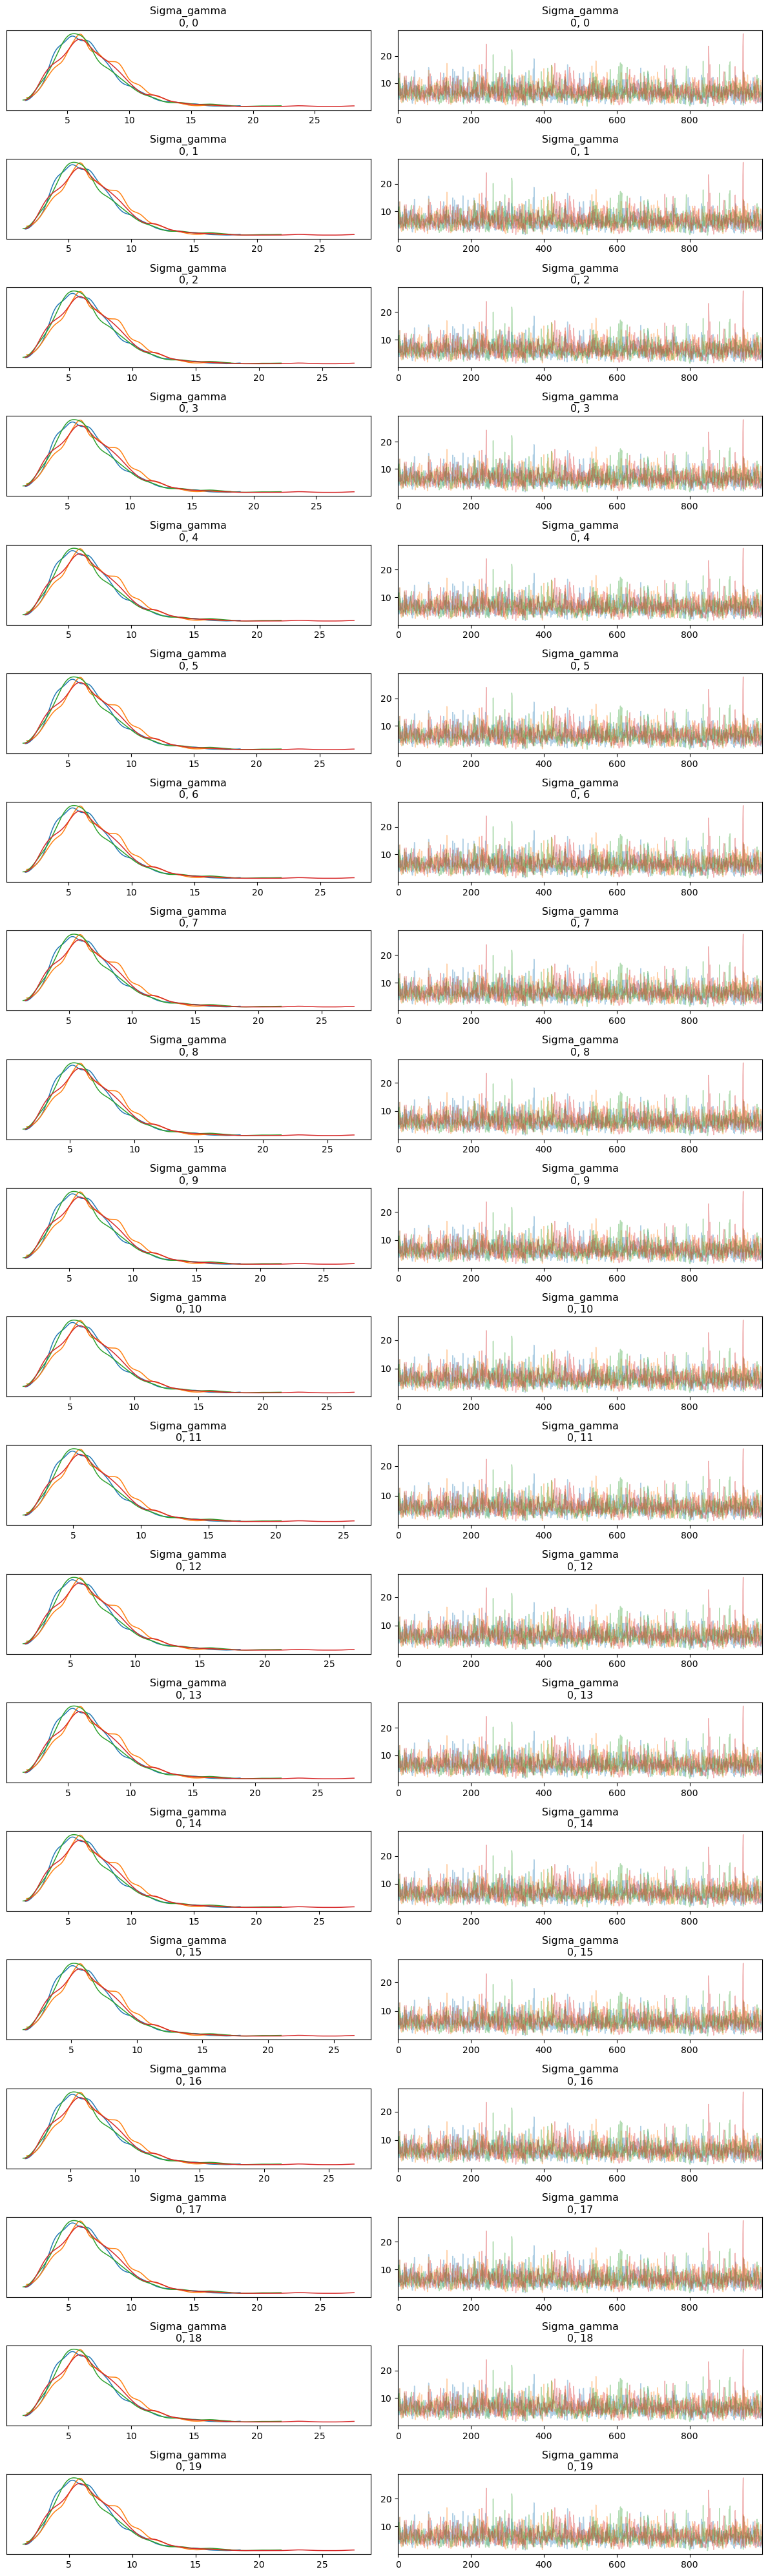

In [104]:
az.plot_trace(spt_lm_no_delta_eff_data, var_names=[
    "Sigma_gamma"], compact=False)
plt.tight_layout()
plt.show()

In [86]:
output_no_delta_data_summary = spt_lm_no_delta_fit.summary()

In [87]:
# FIRST METHOD

# Set the 'Unnamed: 0' column as the index
#output_no_delta_data_summary.set_index('Unnamed: 0', inplace=True)

# Select the covariates you're interested in
#selected_covariates = output_no_delta_data_summary.loc[['xi[1]', 'beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]', 'beta[6]', 'beta[7]', 'beta[8]', 'beta[9]', 'beta[10]', 'beta[11]']]
selected_covariates = output_no_delta_data_summary.loc[['xi[1]', 'beta[1]', 'beta[2]', 'beta[3]']]

# Calculate confidence intervals for the selected covariates
confidence_intervals = {}
for covariate in selected_covariates.index:
    lower_bound = selected_covariates.loc[covariate, '5%']
    upper_bound = selected_covariates.loc[covariate, '95%']
    confidence_intervals[covariate] = (lower_bound, upper_bound)

# Print confidence intervals
for covariate, interval in confidence_intervals.items():
    print(f"{covariate}: {interval}")

xi[1]: (0.991357, 1.68538)
beta[1]: (-1.01891, -0.693709)
beta[2]: (0.0104919, 0.0532541)
beta[3]: (-0.157188, -0.0855019)


In [88]:
# SECOND METHOD
chains_finish = az.from_cmdstanpy(spt_lm_no_delta_fit)
# Assuming you have a single chain named chain_finish
chain = chains_finish
names = ["Single Chain"]  # Rename if desired

# Assuming you have a variable named cov_names that contains the names of the covariates
# Replace this with your actual list of covariate names
#cov_names = ["beta1", "beta2", "beta3", "beta4", "beta5", "beta6", "beta7", "beta8", "beta9", "beta10", "beta11",]
cov_names = ['beta[1]', 'beta[2]', 'beta[3]']

beta_chain = np.vstack(chain.posterior.beta)
hdi_beta = az.hdi(beta_chain, hdi_prob=0.95)

keep = np.array([~(hdi_beta[i, 0] <= 0.0 <= hdi_beta[i, 1]) for i in range(hdi_beta.shape[0])])

# Print out the names of covariates that do not contain zero within their HDI
print("{0}:\n{1}\n".format(names[0], [cov_names[i] for i, k in enumerate(keep) if k]))

Single Chain:
['beta[1]', 'beta[2]', 'beta[3]']



In [89]:
# GENERATED QUANTITIES
new_no_delta_quantities = spt_lm_no_delta_eff.generate_quantities(data=spt_lm_no_delta_data, previous_fit=spt_lm_no_delta_fit)

new_no_delta_quantities.draws().shape

print(new_no_delta_quantities.draws().shape, new_no_delta_quantities.column_names)
for i in range(3):
    print (new_no_delta_quantities.draws()[i,:])

sample_plus = new_no_delta_quantities.draws_pd()
print(type(sample_plus),sample_plus.shape)
names = list(sample_plus.columns.values[7:18])
sample_plus.iloc[0:3, :]

20:58:22 - cmdstanpy - INFO - Chain [1] start processing
20:58:22 - cmdstanpy - INFO - Chain [2] start processing
20:58:22 - cmdstanpy - INFO - Chain [3] start processing
20:58:22 - cmdstanpy - INFO - Chain [4] start processing
20:59:44 - cmdstanpy - INFO - Chain [1] done processing
20:59:44 - cmdstanpy - INFO - Chain [2] done processing
20:59:44 - cmdstanpy - INFO - Chain [4] done processing
20:59:44 - cmdstanpy - INFO - Chain [3] done processing
20:59:52 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".
20:59:52 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".
20:59:52 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".
20:59:52 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".
20:59:52 - cmdstanpy - WARNING - Sample doesn't 

(1000, 4, 5943) ('zero[1]', 'zero[2]', 'zero[3]', 'zero[4]', 'zero[5]', 'zero[6]', 'zero[7]', 'zero[8]', 'zero[9]', 'zero[10]', 'zero[11]', 'zero[12]', 'zero[13]', 'zero[14]', 'zero[15]', 'zero[16]', 'zero[17]', 'zero[18]', 'zero[19]', 'zero[20]', 'zero[21]', 'zero[22]', 'zero[23]', 'zero[24]', 'zero[25]', 'zero[26]', 'zero[27]', 'zero[28]', 'zero[29]', 'zero[30]', 'zero[31]', 'zero[32]', 'zero[33]', 'zero[34]', 'zero[35]', 'zero[36]', 'zero[37]', 'zero[38]', 'zero[39]', 'zero[40]', 'zero[41]', 'zero[42]', 'gamma_pred_sim[1,1]', 'o_pred_sim_t[1,1,1]', 'o_pred_sim_t[1,2,1]', 'o_pred_sim_t[1,3,1]', 'o_pred_sim_t[1,4,1]', 'o_pred_sim_t[1,5,1]', 'o_pred_sim_t[1,6,1]', 'o_pred_sim_t[1,7,1]', 'o_pred_sim_t[1,8,1]', 'o_pred_sim_t[1,9,1]', 'o_pred_sim_t[1,10,1]', 'o_pred_sim_t[1,11,1]', 'o_pred_sim_t[1,12,1]', 'o_pred_sim_t[1,13,1]', 'o_pred_sim_t[1,14,1]', 'o_pred_sim_t[1,15,1]', 'o_pred_sim_t[1,16,1]', 'o_pred_sim_t[1,17,1]', 'o_pred_sim_t[1,18,1]', 'o_pred_sim_t[1,19,1]', 'o_pred_sim_t[1,20

20:59:52 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".


<class 'pandas.core.frame.DataFrame'> (4000, 5946)


,chain__,iter__,draw__,zero[1],zero[2],zero[3],zero[4],zero[5],zero[6],zero[7],...,"Sigma_eta_inv[33,42]","Sigma_eta_inv[34,42]","Sigma_eta_inv[35,42]","Sigma_eta_inv[36,42]","Sigma_eta_inv[37,42]","Sigma_eta_inv[38,42]","Sigma_eta_inv[39,42]","Sigma_eta_inv[40,42]","Sigma_eta_inv[41,42]","Sigma_eta_inv[42,42]"
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.24143,1.61844,0.938898,0.426444,-0.029532,0.984499,-9.67102,0.384909,0.826436,511.899
1,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.34773,1.65900,0.962431,0.437133,-0.030272,1.009170,-9.91342,0.394557,0.847150,524.730
2,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.37219,1.66833,0.967844,0.439591,-0.030442,1.014850,-9.96917,0.396776,0.851914,527.681


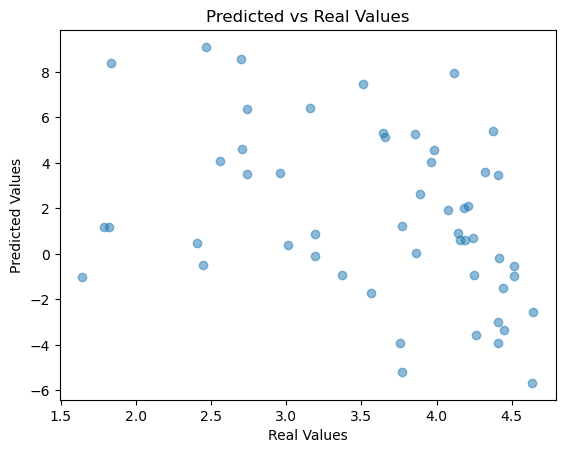

In [90]:
# PLOT

# Assuming your validation set is named 'validation_set'
# and it contains the real values for the ozone levels
# For example, if your validation set has a column named 'ozone_level':
real_values = processed_data_validation['Valore_log']

# Extract the column names that start with 'y_pred_sim'
y_pred_columns = [col for col in sample_plus.columns if col.startswith('y_pred_sim')]

# Select only the columns corresponding to 'y_pred_sim[i,j,k]'
predicted_values = sample_plus[y_pred_columns].values.mean(axis = 0)

# Plot the predicted values against the real values
plt.scatter(valore_array_validation, predicted_values, alpha=0.5)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Real Values')
plt.show()

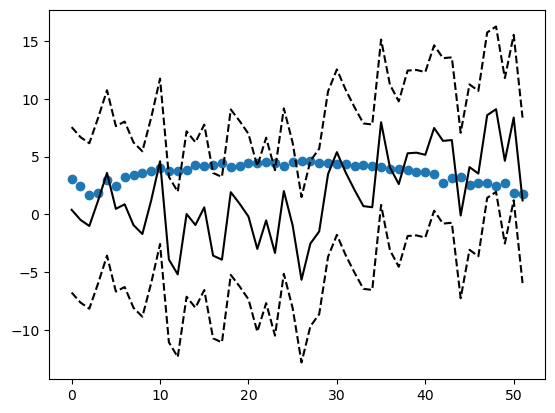

In [91]:
ascisse = np.arange(0, len(predicted_values))
ordinate_real = valore_array_validation

ordinate_predette = predicted_values
SD=np.std(ordinate_predette)

intervallo_confidenza = 1.96*SD #is this right? Quantile of the normal times sd of predictions. Don't know if the previous objects give back a better estimate of it
ordinate_sup = ordinate_predette + intervallo_confidenza
ordinate_inf = ordinate_predette - intervallo_confidenza

plt.scatter(ascisse, ordinate_real)

plt.plot(ascisse, ordinate_predette, color='black')

plt.plot(ascisse, ordinate_sup, linestyle='dashed', color='black')
plt.plot(ascisse, ordinate_inf, linestyle='dashed', color='black')

plt.show()

In [ ]:
print(compute_vmse(real_values, predicted_values))

In [ ]:
#save_stan_fit_and_summary_with_data(spt_lm_fit, output_data_summary, file_name_prefix="Model4_Firas")
save_stan_fit_and_summary_with_data(spt_lm_no_delta_fit, output_no_delta_data_summary, file_name_prefix="Model4_Firas")